This Jupyter notebook shows how to assign stocks into different size portfolios and do CAPM regressions for those 20
value-weighted size portfolios. After that I will do Fama-Macbeth cross sectional regressions where I regress excess returns
on portfolio betas and lagged natural logarithm of the average portfolio market caps.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Read the files
# market_return file includes monthly market returns since the beginning of 2018
# ff3 file includes Fama French 3 factor model coefficients which can be downloaded from Kenneth French's webstie
market_return = pd.read_csv('market_return.csv') # This 
ff3 = pd.read_csv("F-F_Research_Data_Factors.CSV", skiprows=2, skipfooter=99)
ff3 = ff3.rename(columns={ ff3.columns[0]: "date"})


C:\Users\Ville\anaconda3\lib\site-packages\ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [3]:
# create risk-free return index to market data and an excess market return column
months = len(market_return.index) + 2
rf = ff3['RF'][-months:-3]
market_return = market_return[1:]
market_return['risk_free'] = list(rf)
market_return['risk_free'] = market_return['risk_free'] / 100
market_return['vwretd'] = market_return['vwretd']
market_return['excess'] = market_return['vwretd'] - market_return['risk_free']


In [4]:
# Read stock data and create a market cap column
# I used stock data from CRSP
stocks_data = pd.read_csv('stock_data.csv')
stocks_data['cap'] = stocks_data['PRC'] * stocks_data['SHROUT'] / 1000
stocks_data['date'] = pd.to_datetime(stocks_data['date'], format='%d%b%Y')
stocks_data['quantile'] = np.nan


In [5]:
# drop rows with return code C and unnecessary columns such as FACPR and FACSHR. Also, turn return column numbers into float
stocks_data = stocks_data.drop(stocks_data[stocks_data.RET == 'C'].index)
stocks_data = stocks_data.drop(columns=['FACPR', 'FACSHR'])
stocks_data.RET = stocks_data.RET.astype(float)

# Create date difference column
stocks_data['datediff'] = stocks_data['date'].diff()
stocks_data['datediff'] = stocks_data['datediff'].dt.days

# Create lagged market cap and permno column
stocks_data['lagcap'] = stocks_data['cap'].shift(periods=1)
stocks_data['lagpermno'] = stocks_data['PERMNO'].shift(periods=1)

# Drop all rows that don't have a lagged PERMNO equal to the PERMNO 
# Also drop all rows with date difference out of range 28-33 and for date 2018-01-31 (so I don't get any weird lagged market caps)
stocks_data = stocks_data.drop(stocks_data[stocks_data['lagpermno'] != stocks_data['PERMNO']].index)
stocks_data = stocks_data.drop(stocks_data[stocks_data.datediff < 28.0].index)
stocks_data = stocks_data.drop(stocks_data[stocks_data.datediff > 33.0].index)
stocks_data = stocks_data.drop(stocks_data[stocks_data.date == '2018-01-31'].index)
dates = stocks_data.date.unique()

In [6]:
# Read the breakpoints which can be also downloaded from Kenneth French's website
breakpoints = pd.read_csv('ME_Breakpoints.CSV', header=None, skiprows=1, skipfooter=1)

# Filter only the needed months, create string numbers to column names, drop unnecessary columns and again to the column
# renaming in order to match column names with the 
breakpoints = breakpoints[-months:-3]
quantiles = list(range(22))
string_quantiles = [str(int) for int in quantiles]
breakpoints.columns = string_quantiles
true_breakpoints = breakpoints.drop(columns = ['1'])
true_breakpoints['0'] = dates
true_quantiles = list(range(21))
true_string_quantiles = [str(int) for int in true_quantiles]
true_breakpoints.columns = true_string_quantiles
true_breakpoints = true_breakpoints.rename(columns={'0':'date'})


C:\Users\Ville\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


Merge the stock and breakpoints dataframe and assign a quantile for every stock for every month.
My logic is to assign a stock to a new quantile if it is larger than a breakpoint for a quantile below.
For example, if column 1 describes quantile 1 breakpoints and a breakpoint for column 1 is 50, and for column 2 it is 100,
then a stock with a value of 105 gets assigned to a quantile 3 and a stock with a value of 75 gets assigned to a quantile 2.
A stock with a value of 25 then gets assigned to a quantile 1.

In [7]:
crsp = pd.merge(stocks_data, true_breakpoints, left_on='date', right_on = 'date', how='left')
for i in range(1, 20):
    crsp['quantile'].loc[crsp.lagcap > crsp[str(i)]] = int(i)+1
    
# The loop does not assign any stocks to quantile 1, so I fill all stocks that did not get assigned, to quantile 1.
crsp['quantile'] = crsp['quantile'].fillna(1)

# Group portfolios by date and quantile and get returns for every portfolio
crsp['return_sum'] = crsp['RET'] * crsp['lagcap'] 
portfolios = crsp.groupby(['date', 'quantile'])['lagcap', 'return_sum'].sum().reset_index()
portfolios = portfolios.sort_values(by=['quantile', 'date'])
portfolios['return'] = portfolios['return_sum'] / portfolios['lagcap']


C:\Users\Ville\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Ville\anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Create an excess return column with the help of risk free column
portfolios['rf'] = list(rf) * 20
portfolios['rf'] = portfolios['rf'] / 100
portfolios['excess return'] = portfolios['return'] - portfolios['rf']

In [9]:
# Run the regressions and add alphas, betas and r2 to their corresponding lists which are used to create the table
X = market_return['excess']
results_dictionary = {}
alfas = []
alfa_t = []
betas = []
beta_t = []
r2 = []
portfolio = []
excess_returns = []
for i in range(1, 21):
    y = portfolios['excess return'].loc[portfolios['quantile'] == i]
    excess_returns.append(y)
    y.index = X.index
    X = sm.add_constant(X)
    reg = sm.OLS(y, X)
    res = reg.fit()
    alfas.append(round(res.params[0],4))
    betas.append(round(res.params[1],3))
    r2.append(round(res.rsquared,3))
    t_test = res.t_test(np.eye(2))
    alfa_t.append(round(t_test.tvalue[0],3))
    beta_t.append(round(t_test.tvalue[1],3))
    portfolio.append(i)

    
results_dictionary['portfolio'] = portfolio
results_dictionary['a'] = alfas
results_dictionary['t-stats for a'] = alfa_t
results_dictionary['b'] = betas
results_dictionary['t-stats for b'] = beta_t
results_dictionary['r2'] = r2


In [10]:
# visualize the table
results = pd.DataFrame(results_dictionary)
results.set_index('portfolio', inplace=True)
results

,a,t-stats for a,b,t-stats for b,r2
portfolio,,,,,
1,0.0021,0.310,1.375,11.302,0.810
2,-0.0069,-1.196,1.311,12.404,0.837
3,-0.0033,-0.541,1.344,12.062,0.829
4,-0.0056,-1.103,1.293,13.864,0.865
5,-0.0095,-1.868,1.384,14.879,0.881
6,-0.0061,-1.255,1.349,15.213,0.885
7,-0.0080,-1.758,1.457,17.537,0.911
8,-0.0059,-1.826,1.299,21.975,0.942
9,-0.0070,-1.954,1.349,20.743,0.935


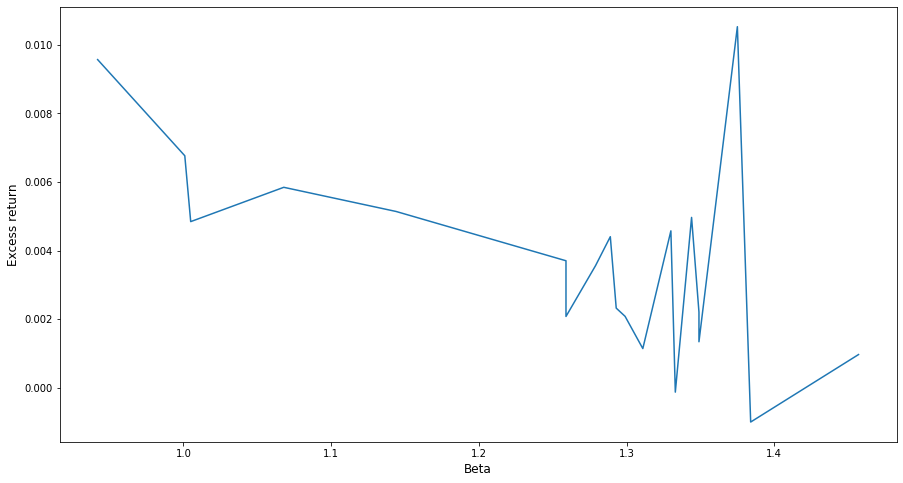

In [11]:
# plot excess returns on beta
import matplotlib.pyplot as plt
avg_list = []
for excess_ret in excess_returns:
    avg_list.append(excess_ret.mean())
betacol = results['b'].tolist()
df = pd.DataFrame()
df['excess_ret'] = avg_list

df['b'] = betacol
df = df.sort_values(by=['b'])
plt.plot(df['b'], df['excess_ret'])
plt.ylabel("Excess return", fontsize=12)
plt.xlabel("Beta", fontsize=12)
fig = plt.gcf()
fig.set_size_inches(15, 8)
plt.show()

In [12]:
# Count the number of statistically significant alphas
from scipy.stats import t
j = 1
for i in alfa_t:
    p_alpha = t.sf(np.abs(i), len(dates)-1)*2
    if p_alpha < 0.05:
        print("Size portfolio", j, "has a statistically significant alpha of", alfas[j-1], "with a p-value of", round(p_alpha,3))
    j += 1

Size portfolio 10 has a statistically significant alpha of -0.0083 with a p-value of 0.022


Now I will do the Fama Macbeth cross-sectional regressions where I regress portfolio excess returns on betas and the natural logarithm of average market caps in portfolio

I first create a lagsize dataframe that has lagged market caps in millions and a natural logarithm of that lagged market cap.
I use the crsp dataframe created before which has all the stocks assigned to their quantiles for every date

In [13]:
lagsize = crsp.groupby(['date', 'quantile'])['lagcap'].mean().reset_index()
lagsize.sort_values(by=['quantile', 'date'], inplace=True)
lagsize['excess return'] = portfolios['excess return']
lagsize['lagcap'] = lagsize['lagcap']
lagsize['log_lagcap'] = np.log(lagsize['lagcap'])

# Add also betas to the quantiles in order to use them  the regressions
lagsize['beta'] = np.nan
for i in range(1, 21):
    lagsize['beta'].loc[lagsize['quantile'] == i] = betacol[i-1]
lagsize.sort_values(by=['date', 'quantile'], inplace=True)


C:\Users\Ville\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Then it is time to do the Fama-Macbeth regressions and add coefficients to their corresponding lists

In [14]:
alphas = []
bones = []
btwos = []
for i in range(len(dates)):
    gap_df = lagsize.loc[lagsize['date'] == dates[i]]
    X = gap_df[['beta', 'log_lagcap']]
    X = sm.add_constant(X)
    y = lagsize['excess return'].loc[lagsize['date'] == dates[i]]
    reg = sm.OLS(y, X)
    res = reg.fit()
    alphas.append(res.params[0])
    bones.append(res.params[1])
    btwos.append(res.params[2])
   

After the regressions I compute the Fama-Macbeth coefficients and t-stats and p-values for the coefficients

In [15]:
import math
import statistics
from scipy.stats import t

# Calculate average Fama-Macbeth coefficient by summing the coefficients and then dividing them by the sample size
average_alpha = sum(alphas) / len(alphas)
average_bones = sum(bones) / len(bones)
average_btwos = sum(btwos) / len(btwos)

# Calculate standard erros for the coefficients by then dividing them by the square root of the sample size
se_alpha = statistics.stdev(alphas) / math.sqrt(len(dates))
se_b1 = statistics.stdev(bones) / math.sqrt(len(dates))
se_b2 = statistics.stdev(btwos) / math.sqrt(len(dates))
print("Average alpha is:", round(average_alpha,5), " Average b1 is:", round(average_bones,4), " Average b2 is:", round(average_btwos,4))

# Calculate t-stats for coefficients by dividing the coefficient by it's standard errors
t_alpha = average_alpha / se_alpha
t_b1 = average_bones / se_b1
t_b2 = average_btwos / se_b2
print("T-stat for alpha is:", round(t_alpha,3), " T-stat for b1 is:", round(t_b1,3), " T-stat for b2 is: ", round(t_b2,3))

# Calculate p-values for coefficients using 31 as the degrees of freedom which is the length of sample size - 1
# This is a two-tailed hypothesis which is why I am doubling the p-value
p_alpha = t.sf(np.abs(t_alpha), len(alphas)-1) * 2
p_b1 = t.sf(np.abs(t_b1), len(bones)-1)*2
p_b2 = t.sf(np.abs(t_b2), len(btwos)-1)*2
print("P-value for alpha is:", round(p_alpha,4), "P-value for b1 is:", round(p_b1,4), "P-value for b2 is:", round(p_b2,4))


Average alpha is: 0.03498  Average b1 is: -0.0202  Average b2 is: -0.0007
T-stat for alpha is: 1.789  T-stat for b1 is: -1.488  T-stat for b2 is:  -0.624
P-value for alpha is: 0.0833 P-value for b1 is: 0.1469 P-value for b2 is: 0.5375


C:\Users\Ville\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Second argument 'b1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  import sys
C:\Users\Ville\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Second argument 'b2' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  


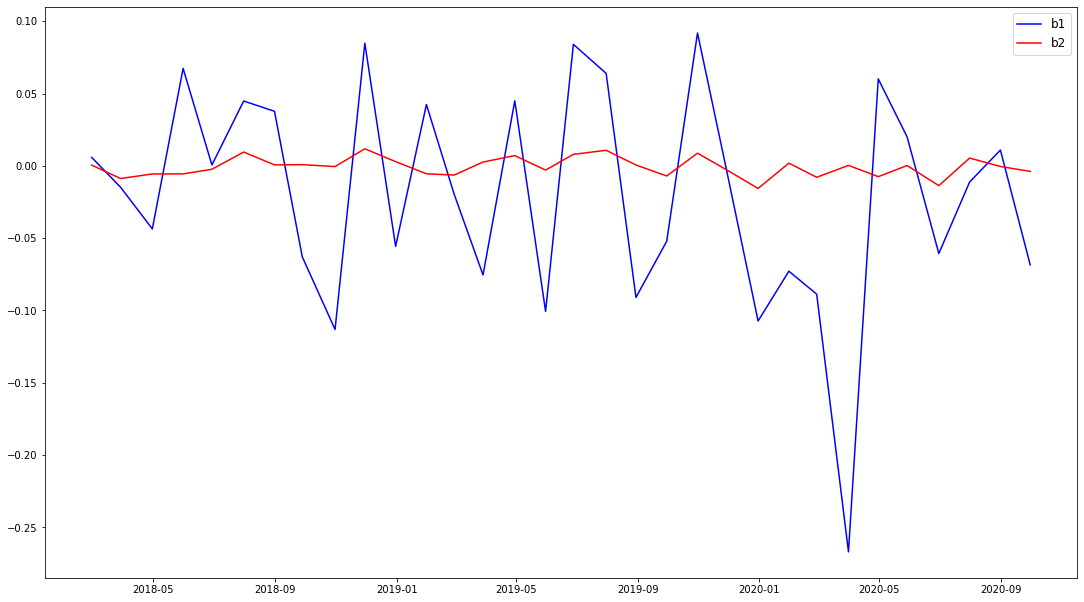

In [16]:
# Plot b1 and b2 on date
import matplotlib.pyplot as plt
plot_df = pd.DataFrame()
plot_df['date'] = dates
plot_df['b1'] = bones
plot_df['b2'] = btwos
plt.plot('date', 'b1', data=plot_df, color='blue')
plt.plot('date', 'b2', data=plot_df, color='red')
plt.legend(prop={'size': 12})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

